RDD IMPLEMENTATION

SETUP
LOAD LIBRARIES

In [0]:
import csv
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from operator import add
from matplotlib import pyplot as plt


In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/Assignment_3_data_scrubbing_using_rdds.ipynb', name='Assignment_3_data_scrubbing_using_rdds.ipynb', size=26170, modificationTime=1645433662000),
 FileInfo(path='dbfs:/FileStore/tables/Assignment_4_character_counting_OK.ipynb', name='Assignment_4_character_counting_OK.ipynb', size=40680, modificationTime=1645709705000),
 FileInfo(path='dbfs:/FileStore/tables/Extraction_of_Devicestatus.ipynb', name='Extraction_of_Devicestatus.ipynb', size=9994, modificationTime=1645273933000),
 FileInfo(path='dbfs:/FileStore/tables/HW4-1.mhtml', name='HW4-1.mhtml', size=3203959, modificationTime=1645842516000),
 FileInfo(path='dbfs:/FileStore/tables/HW4.mhtml', name='HW4.mhtml', size=3203959, modificationTime=1645842338000),
 FileInfo(path='dbfs:/FileStore/tables/W10D1_IoT.ipynb', name='W10D1_IoT.ipynb', size=10412, modificationTime=1651050539000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=16450

In [0]:
import os
os.environ['fileroot'] = "clinicaltrial_2021_csv"

In [0]:
fileroot =  "clinicaltrial_2021_csv"
dbutils.fs.cp("/FileStore/tables/"+fileroot+".gz","file:/tmp/clinicaltrial_2021_csv.gz")

Out[4]: True

In [0]:
%sh
gunzip -d /tmp/ /tmp/clinicaltrial_2021_csv.gz

gzip: /tmp/ is a directory -- ignored


In [0]:
dbutils.fs.mv("file:/tmp/clinicaltrial_2021_csv","dbfs:/FileStore/tables/clinicaltrial_2021.csv",True)

Out[6]: True

In [0]:
dbutils.fs.head("dbfs:/FileStore/tables/clinicaltrial_2021.csv")

[Truncated to first 65536 bytes]
Out[7]: "Id|Sponsor|Status|Start|Completion|Type|Submission|Conditions|Interventions\r\nNCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||\r\nNCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|\r\nNCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|\r\nNCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|\r\nNCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|\r\nNCT02757209|Consorzio Futuro in Ricerca|Completed|Apr 2016|Jan 2018|Interventional|Apr 2016|Asthma|Fluticasone,Xhance,Budesonide,Formoterol Fumarate,Salmeterol Xinafoate\r\nNCT02752438|Ankara University|Unkn

In [0]:
dbutils.fs.head("dbfs:/FileStore/tables/pharma.csv")

[Truncated to first 65536 bytes]
Out[8]: '"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"\n"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to ind

In [0]:
dbutils.fs.head("dbfs:/FileStore/tables/mesh.csv")

[Truncated to first 65536 bytes]
Out[9]: 'term,tree\r\nCalcimycin,D03.633.100.221.173\r\nA-23187,D03.633.100.221.173\r\nTemefos,D02.705.400.625.800\r\nTemefos,D02.705.539.345.800\r\nTemefos,D02.886.300.692.800\r\nAbate,D02.705.400.625.800\r\nAbate,D02.705.539.345.800\r\nAbate,D02.886.300.692.800\r\nDifos,D02.705.400.625.800\r\nDifos,D02.705.539.345.800\r\nDifos,D02.886.300.692.800\r\nAbattoirs,J01.576.423.200.700.100\r\nAbattoirs,J03.540.020\r\nAbbreviations as Topic,L01.559.598.400.556.131\r\nAcronyms as Topic,L01.559.598.400.556.131\r\nAbdomen,A01.923.047\r\n"Abdomen, Acute",C23.888.592.612.054.200\r\n"Abdomen, Acute",C23.888.821.030.249\r\nAbdominal Injuries,C26.017\r\nAbdominal Neoplasms,C04.588.033\r\nAbdominal Muscles,A02.633.567.050\r\nCremaster Muscle,A02.633.567.050\r\nPyramidalis Muscle,A02.633.567.050\r\nQuadratus Abdominis,A02.633.567.050\r\nTransversus Abdominis,A02.633.567.050\r\nAbducens Nerve,A08.800.800.120.030\r\nAbelson murine leukemia virus,B04.613.807.375.525.020\r

Load Data
create variable name for file location

In [0]:
file_location = "/FileStore/tables/clinicaltrial_2021.csv"
pharma_location = "/FileStore/tables/pharma.csv"
mesh_location = "/FileStore/tables/mesh.csv"

In [0]:
clinicaltrial_2021 = sc.textFile(file_location)\
                      .map(lambda line: line.split('|'))\
                      .filter(lambda line: len(line)>1)

header = clinicaltrial_2021.first()
clinicaltrial_2021=clinicaltrial_2021.filter(lambda x: x!=header)

In [0]:
#clinicaltrial_2021 = sc.textFile(file_location)
#header = clinicaltrial_2021.first()
#clinicaltrial_2021 = clinicaltrial_2021.filter(lambda x: x!= header)\
#.mapPartitions(lambda x: csv.reader(x, delimiter="|"))

In [0]:
mesh = sc.textFile(mesh_location)
mesh_header = mesh.first()
mesh = mesh.filter(lambda x: x!= header).mapPartitions(lambda x: csv.reader(x, delimiter=","))

In [0]:
pharma = sc.textFile(pharma_location)
pharma_header = pharma.first()
pharma = pharma.filter(lambda x: x!= header).mapPartitions(lambda x: csv.reader(x, delimiter=","))

In [0]:
clinicaltrial_2021.collect()

Out[15]: [['NCT02758028',
  'The University of Hong Kong',
  'Recruiting',
  'Aug 2005',
  'Nov 2021',
  'Interventional',
  'Apr 2016',
  '',
  ''],
 ['NCT02751957',
  'Duke University',
  'Completed',
  'Jul 2016',
  'Jul 2020',
  'Interventional',
  'Apr 2016',
  'Autistic Disorder,Autism Spectrum Disorder',
  ''],
 ['NCT02758483',
  'Universidade Federal do Rio de Janeiro',
  'Completed',
  'Mar 2017',
  'Jan 2018',
  'Interventional',
  'Apr 2016',
  'Diabetes Mellitus',
  ''],
 ['NCT02759848',
  'Istanbul Medeniyet University',
  'Completed',
  'Jan 2012',
  'Dec 2014',
  'Observational',
  'May 2016',
  'Tuberculosis,Lung Diseases,Pulmonary Disease',
  ''],
 ['NCT02758860',
  'University of Roma La Sapienza',
  'Active, not recruiting',
  'Jun 2016',
  'Sep 2020',
  'Observational [Patient Registry]',
  'Apr 2016',
  'Diverticular Diseases,Diverticulum,Diverticulosis',
  ''],
 ['NCT02757209',
  'Consorzio Futuro in Ricerca',
  'Completed',
  'Apr 2016',
  'Jan 2018',
  'Interven

QUESTION 1
Number of Studies in the data set

In [0]:
Parent_Company = 1

In [0]:
clinicaltrial_2021.count()

Out[17]: 387261

QUESTION 2 You should list all the types (as contained in the Type column) of studies in the dataset along with
the frequencies of each type

In [0]:
clinicaltrial_2021.collect()

Out[18]: [['NCT02758028',
  'The University of Hong Kong',
  'Recruiting',
  'Aug 2005',
  'Nov 2021',
  'Interventional',
  'Apr 2016',
  '',
  ''],
 ['NCT02751957',
  'Duke University',
  'Completed',
  'Jul 2016',
  'Jul 2020',
  'Interventional',
  'Apr 2016',
  'Autistic Disorder,Autism Spectrum Disorder',
  ''],
 ['NCT02758483',
  'Universidade Federal do Rio de Janeiro',
  'Completed',
  'Mar 2017',
  'Jan 2018',
  'Interventional',
  'Apr 2016',
  'Diabetes Mellitus',
  ''],
 ['NCT02759848',
  'Istanbul Medeniyet University',
  'Completed',
  'Jan 2012',
  'Dec 2014',
  'Observational',
  'May 2016',
  'Tuberculosis,Lung Diseases,Pulmonary Disease',
  ''],
 ['NCT02758860',
  'University of Roma La Sapienza',
  'Active, not recruiting',
  'Jun 2016',
  'Sep 2020',
  'Observational [Patient Registry]',
  'Apr 2016',
  'Diverticular Diseases,Diverticulum,Diverticulosis',
  ''],
 ['NCT02757209',
  'Consorzio Futuro in Ricerca',
  'Completed',
  'Apr 2016',
  'Jan 2018',
  'Interven

In [0]:
#header

In [0]:
Type, Sponsor = 5, 1

In [0]:
clinicaltrial_2021.map(lambda col: col[Type])\
.filter(lambda x: x!='')\
.map(lambda x: (x, 1))\
.reduceByKey(add)\
.map(lambda x: (x[1], x[0]))\
.sortByKey(ascending=False)\
.map(lambda x: (x[1], x[0])).collect()

Out[21]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

QUESTION 3  The top 5 conditions (from Conditions) with their frequencies

In [0]:
header

Out[22]: ['Id',
 'Sponsor',
 'Status',
 'Start',
 'Completion',
 'Type',
 'Submission',
 'Conditions',
 'Interventions']

In [0]:
# Conditions appears in index 7 or column#
Conditions = 7

In [0]:
clinicaltrial_2021.map(lambda col: col[Conditions])\
.filter(lambda z: z!="")\
.flatMap(lambda z: z.split(","))\
.map(lambda z: (z,1))\
.reduceByKey(add)\
.sortBy(lambda z: z[1],ascending=False)\
.take(5)

Out[24]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

QUESTION 4

In [0]:
finalRDD = clinicaltrial_2021.map(lambda col: col[Conditions])\
.filter(lambda x: x!='')\
.flatMap(lambda x: x.split(','))\
.map(lambda x: (x, 1))
finalRDD.collect()

Out[25]: [('Autistic Disorder', 1),
 ('Autism Spectrum Disorder', 1),
 ('Diabetes Mellitus', 1),
 ('Tuberculosis', 1),
 ('Lung Diseases', 1),
 ('Pulmonary Disease', 1),
 ('Diverticular Diseases', 1),
 ('Diverticulum', 1),
 ('Diverticulosis', 1),
 ('Asthma', 1),
 ('Hypoventilation', 1),
 ('Lymphoma', 1),
 ('Myositis', 1),
 ('Diabetes Mellitus', 1),
 ('Hypertension', 1),
 ('Periodontal Diseases', 1),
 ('Diabetes Mellitus', 1),
 ('Appendicitis', 1),
 ('Stomach Ulcer', 1),
 ('Cholecystolithiasis', 1),
 ('Cholelithiasis', 1),
 ('Gallstones', 1),
 ('Hookworm Infections', 1),
 ('Celiac Disease', 1),
 ('Ascites', 1),
 ('Chronic Pain', 1),
 ('Substance-Related Disorders', 1),
 ('Opioid-Related Disorders', 1),
 ('Narcotic-Related Disorders', 1),
 ('Behavior', 1),
 ('Sleep Apnea Syndromes', 1),
 ('Sleep Apnea', 1),
 ('Tyrosinemias', 1),
 ('Hemangioma', 1),
 ('Hypertension', 1),
 ('Carcinoma', 1),
 ('Lymphoma', 1),
 ('Iatrogenic Disease', 1),
 ('Cystic Fibrosis', 1),
 ('Fibrosis', 1),
 ('Motor Neu

In [0]:
meshpair = mesh.map(lambda obs: (obs[0], obs[1]))
meshpair.take(5)

Out[26]: [('term', 'tree'),
 ('Calcimycin', 'D03.633.100.221.173'),
 ('A-23187', 'D03.633.100.221.173'),
 ('Temefos', 'D02.705.400.625.800'),
 ('Temefos', 'D02.705.539.345.800')]

In [0]:
finalRDD.join(meshpair)\
.map(lambda x: x[1][1])\
.map(lambda x: x.split('.'))\
.map(lambda x: x[0])\
.map(lambda x: (x,1))\
.reduceByKey(add)\
.sortBy(lambda x: x[1], ascending =False)\
.take(10)

Out[27]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310),
 ('C06', 85646),
 ('C08', 70720),
 ('C13', 42599),
 ('C18', 41276),
 ('C12', 40161)]

QUESTION 5 Data pre-processing

In [0]:
# to understand the question i have to upload pharma data set called pharma #

pharma = sc.textFile(pharma_location)\
.map(lambda line: line.split(","))\
.filter(lambda line: len(line)>1)
header = pharma.first()
pharma = pharma.filter(lambda x: x!= header)

In [0]:
pharma.collect()

Out[29]: [['"Abbott Laboratories"',
  '"Abbott Laboratories"',
  '"$5',
  '475',
  '000"',
  '"$0"',
  '"$5',
  '475',
  '000"',
  '"2013"',
  '"20131227"',
  '"government-contracting-related offenses"',
  '"False Claims Act and related"',
  '"kickbacks and bribery"',
  '"Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the company\'s carotid',
  ' biliary and peripheral vascular products."',
  '"federal"',
  '"agency action"',
  '"Justice Department Civil Division"',
  '"civil"',
  '""',
  '""',
  '""',
  '""',
  '""',
  '""',
  '""',
  '""',
  '""',
  '""',
  '""',
  '"USA"',
  '"Illinois"',
  '"publicly traded"',
  '"ABT"',
  '"pharmaceuticals"',
  '"pharmaceuticals"',
  '"https://www.justice.gov/opa/pr/abbott-laboratories-pays-us-5475-million-settle-claims-company-paid-kickbacks-physicians"',
  '""'],
 ['"Abbott Laboratories Inc."',
  '"AbbVie"',
  '"$1',
  '500',
  '000',
  '0

In [0]:
# viewing the columns to see the index of parent company

pharma = sc.textFile(pharma_location)\
.map(lambda line: line.split(","))\
.filter(lambda line: len(line)>1)
column_pharma = pharma.first()
pharma = pharma.filter(lambda x: x!= header)

In [0]:
column_pharma

Out[31]: ['"Company"',
 '"Parent_Company"',
 '"Penalty_Amount"',
 '"Subtraction_From_Penalty"',
 '"Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting"',
 '"Penalty_Year"',
 '"Penalty_Date"',
 '"Offense_Group"',
 '"Primary_Offense"',
 '"Secondary_Offense"',
 '"Description"',
 '"Level_of_Government"',
 '"Action_Type"',
 '"Agency"',
 '"Civil/Criminal"',
 '"Prosecution_Agreement"',
 '"Court"',
 '"Case_ID"',
 '"Private_Litigation_Case_Title"',
 '"Lawsuit_Resolution"',
 '"Facility_State"',
 '"City"',
 '"Address"',
 '"Zip"',
 '"NAICS_Code"',
 '"NAICS_Translation"',
 '"HQ_Country_of_Parent"',
 '"HQ_State_of_Parent"',
 '"Ownership_Structure"',
 '"Parent_Company_Stock_Ticker"',
 '"Major_Industry_of_Parent"',
 '"Specific_Industry_of_Parent"',
 '"Info_Source"',
 '"Notes"']

In [0]:
Parent_Company = 1
Sponsor = 1

In [0]:
#broadcast function was used to merge the two RDDS together with the sponsor column and the parent company column #
sponsor_rdd = clinicaltrial_2021.map(lambda col: col[Sponsor])
pharma_rdd = pharma.map(lambda col: col[Parent_Company])\
.map(lambda x:x.strip('\"'))                          
pharma_rdd = sc.broadcast(pharma_rdd.collect())                        
                          

In [0]:
sponsor_rdd.filter(lambda y: y not in pharma_rdd.value)\
.map(lambda y: (y,1))\
.reduceByKey(add)\
.sortBy(lambda y: y[1], ascending=False)\
.take(10)

Out[34]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

QUESTION 6 
filtering function performed,since Status is in index 2 and Completion is in index 4

In [0]:
# Status and Completion appears in index 2 amd 4 respectively #

clinicaltrial_2021.map(lambda col: [col[s] for s in[2,4]]).take(5)

Out[35]: [['Status', 'Completion'],
 ['Recruiting', 'Nov 2021'],
 ['Completed', 'Jul 2020'],
 ['Completed', 'Jan 2018'],
 ['Completed', 'Dec 2014']]

In [0]:
 clinicaltrial_2021.map(lambda col: [col[s] for s in[2,4]])\
.filter(lambda s: s[0] == 'Completed')\
.map(lambda s: s[1])\
.filter(lambda s: s!= '')\
.map(lambda s: list(s.split()))\
.filter(lambda s: s[1] == "2021")\
.groupByKey().mapValues(len)\
.sortBy(lambda s: s[1], ascending=False)\
.collect()

Out[36]: [('Mar', 1227),
 ('Jan', 1131),
 ('Jun', 1094),
 ('May', 984),
 ('Apr', 967),
 ('Feb', 934),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

In [0]:
## create a variable name called completed ##

completed =  clinicaltrial_2021.map(lambda col: [col[s] for s in[2,4]])\
.filter(lambda s: s[0] == 'Completed')\
.map(lambda s: s[1])\
.filter(lambda s: s!= '')\
.map(lambda s: list(s.split()))\
.filter(lambda s: s[1] == "2021")\
.groupByKey().mapValues(len)\
.sortBy(lambda s: s[1], ascending=False)


In [0]:
## creating a function called month_arrange to arrange the months in January to December (i.e decending order)##

def month_arrange (month):
    if month[0]=='Jan':
        return (1,month)
    elif month[0]=='Feb':
        return (2,month)
    elif month[0]=='Mar':
        return (3,month)
    elif month[0]=='Apr':
        return (4,month)
    elif month[0]=='May':
        return (5,month)
    elif month[0]=='Jun':
        return (6,month)
    elif month[0]=='Jul':
        return (7,month)
    elif month[0]=='Aug':
        return (8,month)
    elif month [0]=='Sep':
        return (9,month)
    elif month[0]=='Oct':
        return (10,month)
    elif month[0]=='Nov':
        return (11,month)
    else:
        return (12,month)
    

In [0]:
## testing the function and assign as variable completed1
completed1 = completed.map(month_arrange)\
.sortBy(lambda y: y[0],ascending=True)\
.map(lambda y:y[1])
completed1.collect()

Out[39]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

QUESTION 6 VISUALIZATION USING MATPLOTLIB

In [0]:
month = completed1.map(lambda x: x[0]).collect()
count = completed1.map(lambda x: x[1]).collect()

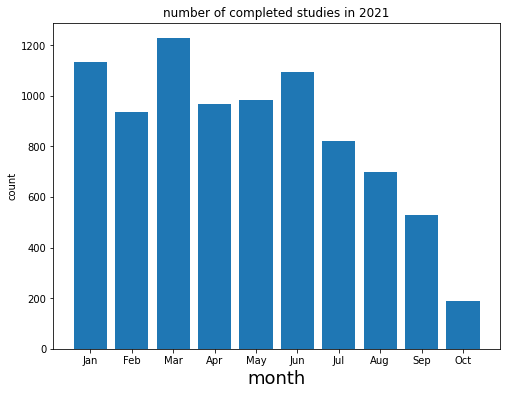

In [0]:
plt.figure(figsize=(8,6))
plt.bar(month,count)
plt.xlabel('month',fontsize=18)
plt.ylabel('count')
plt.title('number of completed studies in 2021')
plt.show()